In [1]:
# Import all needed library
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pybert as pb

In [2]:
# Import the data using pybert (automatically detected)
data = pb.importData('variscan.bin')
print(data) # electrode number and data size
print(data.tokenList()) # see what's in the data

13/02/20 - 08:06:14 - pyGIMLi - INFO - imported:  Data: Electrodes: 48 data: 798


Data: Electrodes: 48 data: 798
SensorIdx: a b m n  Data: M1 M10 M11 M12 M13 M14 M15 M16 M17 M18 M19 M2 M20 M3 M4 M5 M6 M7 M8 M9 TM0 TM1 TM10 TM11 TM12 TM13 TM14 TM15 TM16 TM17 TM18 TM19 TM2 TM20 TM3 TM4 TM5 TM6 TM7 TM8 TM9 bat_rx bat_tx err gm i ip iperr k r rhoa rs_check sp stacks temp u vab valid 


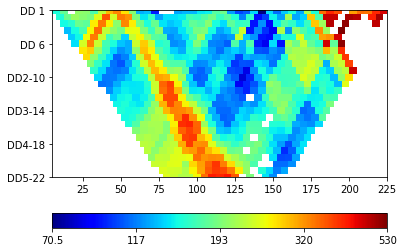

In [3]:
# Compute apparent resistivity by U/I*k, put both k and app. res. into the data
data.set('k', pb.geometricFactors(data))
data.set('rhoa', data('u') / data('i') * data('k'))
pb.show(data);

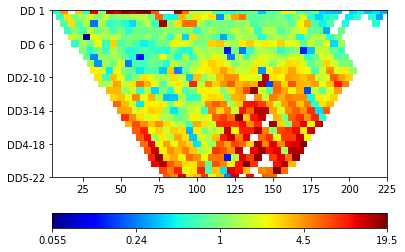

In [5]:
pb.show(data, data('err')*10); # mV/V converted into %

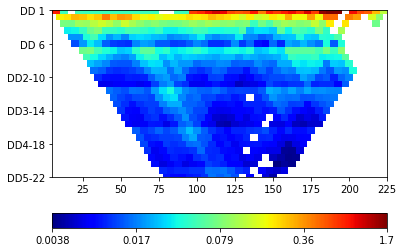

In [6]:
pb.show(data, -data('u'));

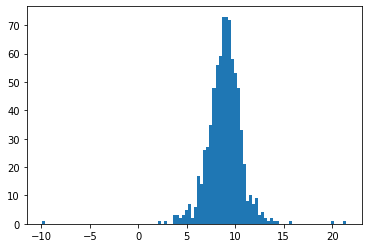

In [8]:
import matplotlib.pyplot as plt
plt.hist(data('ip'), bins=100);  # pb.pg.plt works as well

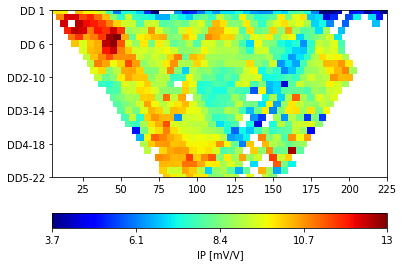

In [9]:
data.markInvalid(data('ip') < 3)
data.markInvalid(data('ip') > 13)  # mV/V
data.removeInvalid()
pb.show(data, 'ip', logScale=False, label='IP [mV/V]');

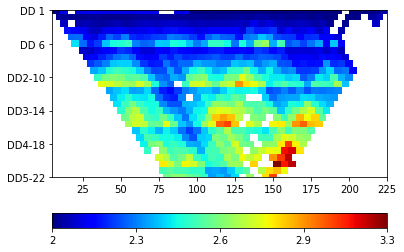

In [10]:
# apparently the measured (stacking) error is not good for inversion - estimate
ert = pb.ERTManager()
error = ert.estimateError(data=data, relativeError=0.02, absoluteUError=50e-6) # 3% + 300 µV
data.set('err', error)
pb.show(data, data('err')*100);

In [11]:
# Create a ERT manager instance using the data file
ert.setData(data)

(<matplotlib.axes._subplots.AxesSubplot at 0x2c53a250f98>, None)

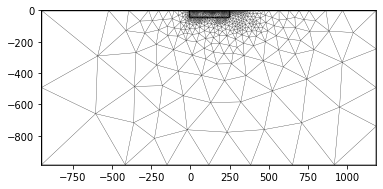

In [12]:
mesh = pg.meshtools.createParaMesh(data, quality=34.5, paraDepth=45)
pg.show(mesh)

In [13]:
# do the inversion
ert.invert(mesh=mesh)

13/02/20 - 08:06:59 - pyGIMLi - INFO - Found 2 regions.
13/02/20 - 08:06:59 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)
13/02/20 - 08:06:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
13/02/20 - 08:06:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
13/02/20 - 08:06:59 - pyGIMLi - INFO - Set default startmodel to median(data values)=169.2229517393369
13/02/20 - 08:06:59 - pyGIMLi - INFO - Created startmodel from forward operator: 1068 [169.2229517393369,...,169.2229517393369]


<class 'pygimli.physics.ert.ert.BertModelling'>._applyRegionProperties(C:\Guenther.T\src\gimli\gimli\python\pygimli\frameworks\modelling.py:261) : True




(<matplotlib.axes._subplots.AxesSubplot at 0x2c53a2a2f28>,
 <matplotlib.colorbar.Colorbar at 0x2c539c4f6d8>)

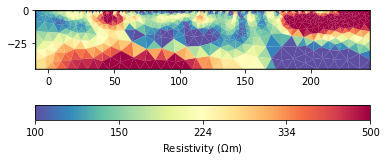

In [14]:
ert.showResult(cMin=100, cMax=500, cMap='Spectral_r')

In [16]:
import numpy as np
# Have a look at the error-weighted misfit (log a - log b = log(a/b))
misfit = np.log10(ert.inv.response()/data('rhoa')) / data('err')
print(min(misfit), max(misfit))
pb.plotERTData(data, vals=misfit, cMap='bwr', cMin=-2, cMax=2)

ArgumentError: Python argument types in
    RVector.__call__(RVector)
did not match C++ signature:
    __call__(GIMLI::Vector<double> {lvalue}, GIMLI::Vector<bool> bv)
    __call__(GIMLI::Vector<double> {lvalue}, GIMLI::Vector<long long> iVec)
    __call__(GIMLI::Vector<double> {lvalue}, std::vector<long long, std::allocator<long long> > siArray)
    __call__(GIMLI::Vector<double> {lvalue}, GIMLI::Vector<unsigned long long> iArray)
    __call__(GIMLI::Vector<double> {lvalue}, std::pair<unsigned long long, long long> pair)
    __call__(GIMLI::Vector<double> {lvalue}, unsigned long long start, long long end)

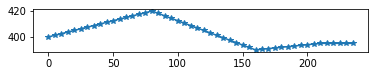

In [17]:
import pygimli as pg
import numpy as np
import matplotlib.pyplot as plt

# assume we have some topography measured on 4 points by GPS
topoX = [0, 80, 160, 210]
topoZ = [400, 420, 390, 395]
ex = pg.x(data)
ez = np.interp(ex, topoX, topoZ)
fig, ax = plt.subplots()
ax.plot(ex, ez, '*-')
ax.set_aspect(1.0)

In [65]:
# so we need to set the electrode positions
for i in range(data.sensorCount()):
    data.setSensorPosition(i, [ex[i], 0, ez[i]])
    
data.save('variscanTopo.ohm', 'a b m n u i err ip', "x z")

1

None None
creating mesh...
Mesh: Nodes: 918 Cells: 1647 Boundaries: 2564
Mesh: Nodes: 918 Cells: 1647 Boundaries: 2564


(<matplotlib.axes._subplots.AxesSubplot at 0x1fa491ba0f0>,
 <matplotlib.colorbar.Colorbar at 0x1fa492d09b0>)

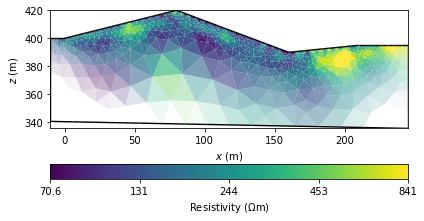

In [63]:
# Just to make sure we forgot everything (wrong geometric factor and rhoa)
# ert = pb.ERTManager('variscanTopo.ohm')
ert = pb.ERTManager(data)
ert.invert()
ert.showResult()

In [60]:
# we can also use a ready function
#topoXZ = np.column_stack((topoX, topoZ))
#pos = pg.meshtools.tapeMeasureToCoordinates(data.sensorPositions(), topoXZ)
#print(pos)
# better implement a function ert.applyTopography(topoXZ)